In [1]:
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.signal import butter, lfilter, iirnotch
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
def bandpass_filter(data, low, high, fs, order=4):
    nyq = 0.5 * fs
    low /= nyq
    high /= nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data, axis=-1)

def butter_filter(data, cutoff, fs, btype='low', order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = lfilter(b, a, data, axis=0)
    return y


def notch_filter(signal, fs, freq=60, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return lfilter(b, a, signal, axis=0)

In [3]:
debug = False

# Setting up the board
if debug:
    # Create a synthetic board for debugging purposes
    board_id = BoardIds.SYNTHETIC_BOARD
    params = BrainFlowInputParams()
else:
    # Setting up the board
    params = BrainFlowInputParams()
    params.serial_number = 'UN-2023.02.30'
    board_id = BoardIds.UNICORN_BOARD
    
board = BoardShim(board_id, params)

# Getting specific board details
channels = board.get_eeg_channels(board_id) #EEG Channels
timestamp_channel = board.get_timestamp_channel(board_id) # Timestamp channel
marker_channel = board.get_marker_channel(board_id) # Marker channel for synchronization
sampling_rate = BoardShim.get_sampling_rate(board_id) # Hz

In [72]:
dataset = np.loadtxt(r"..//dataset3.csv", delimiter=",")

In [73]:
eegdata = dataset[:, channels]
markers = dataset[:, marker_channel]

In [74]:
temp_idx = np.arange(0, len(markers))
temp_idx = temp_idx[markers != 0]
# temp_idx = temp_idx[markers[temp_idx] != 67]

buffer = 750
window_size = int(3*sampling_rate)

eeg_samples = []
labels = []

for i in range(len(temp_idx)):
    temp_eeg = eegdata[ temp_idx[i]:temp_idx[i]+window_size+buffer, :]
    temp_eeg = butter_filter(temp_eeg, 3, sampling_rate, btype='high', order=2)
    temp_eeg = butter_filter(temp_eeg, 80, sampling_rate, btype='low', order=2)
    temp_eeg = notch_filter(temp_eeg, sampling_rate, freq=60)
    temp_eeg = temp_eeg[buffer:, :]
    temp_eeg -= np.mean(temp_eeg, axis=1, keepdims=True)
    temp_mean = np.mean(temp_eeg, axis=0, keepdims=True)
    temp_std = np.std(temp_eeg, axis=0, keepdims=True)
    temp_eeg = (temp_eeg - temp_mean) / temp_std
    
    eeg_samples.append(temp_eeg)
    labels.append(markers[temp_idx[i]])

eeg_samples = np.array(eeg_samples)
labels = np.array(labels)

In [75]:
labels[labels == 67] = 0
print(labels)

print(labels.shape)
print(eeg_samples.shape)
eeg_samples = np.transpose(eeg_samples, (0, 2, 1))

[0. 1. 0. 1. 0. 2. 0. 2. 0. 2. 0. 1. 0. 1. 0. 2. 0. 1. 0. 2. 0. 1. 0. 2.
 0. 2. 0. 2. 0. 1. 0. 1. 0. 1. 0. 2. 0. 1. 0. 2. 0. 1. 0. 2. 0. 1. 0. 2.
 0. 1. 0. 2. 0. 2. 0. 2. 0. 1. 0. 1. 0. 2. 0. 2. 0. 2. 0. 1. 0. 2. 0. 1.
 0. 2. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 2. 0. 2. 0. 1. 0. 1. 0. 2. 0. 2.
 0. 1. 0. 2. 0. 2. 0. 2. 0. 2. 0. 1. 0. 1. 0. 1. 0. 2. 0. 2. 0. 1. 0. 1.
 0.]
(121,)
(121, 750, 8)


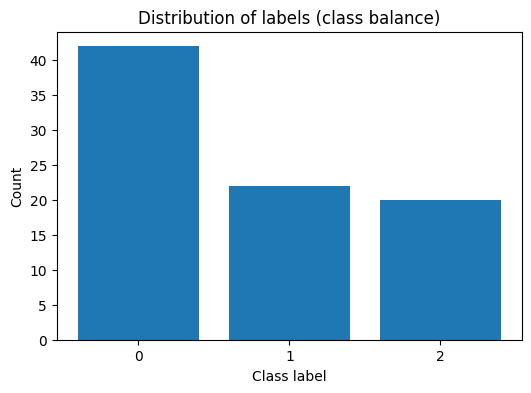

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    eeg_samples, labels, test_size=0.3, shuffle=False
)

plt.figure(figsize=(6,4))
plt.hist(y_train, bins=np.arange(y_train.min(), y_train.max()+2)-0.5, rwidth=0.8)
plt.xticks(np.unique(y_train))
plt.xlabel("Class label")
plt.ylabel("Count")
plt.title("Distribution of labels (class balance)")
plt.show()


from sklearn.utils import resample

def random_undersample(X, y, random_state=0):
    """
    Undersample majority classes to match the minority class count.
    X: (N, channels, times)
    y: (N,)
    Returns X_res, y_res
    """
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    keep_idx = []
    for cls in classes:
        idx_cls = np.where(y == cls)[0]
        if len(idx_cls) <= min_count:
            keep = idx_cls
        else:
            keep = resample(idx_cls, replace=False, n_samples=min_count, random_state=random_state)
        keep_idx.append(keep)

    keep_idx = np.concatenate(keep_idx)
    # optionally shuffle the result
    rng = np.random.RandomState(random_state)
    rng.shuffle(keep_idx)

    return X[keep_idx], y[keep_idx]


X_train, y_train = random_undersample(X_train, y_train)

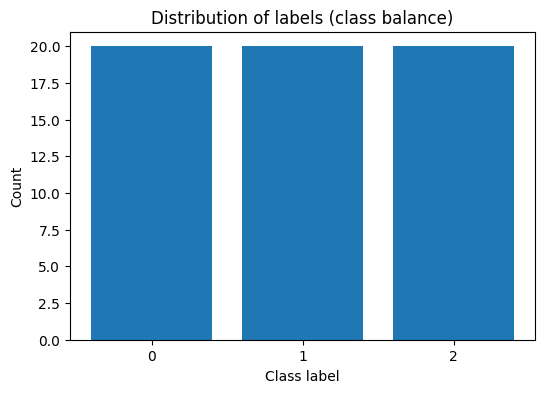

In [77]:
plt.figure(figsize=(6,4))
plt.hist(y_train, bins=np.arange(y_train.min(), y_train.max()+2)-0.5, rwidth=0.8)
plt.xticks(np.unique(y_train))
plt.xlabel("Class label")
plt.ylabel("Count")
plt.title("Distribution of labels (class balance)")
plt.show()

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mne.decoding import CSP  # CSP implementation in MNE

# -----------------------------
# Build pipeline: CSP → LDA
# -----------------------------
clf = Pipeline([
    ("csp", CSP(n_components=4, reg=None, log=True, norm_trace=False)),
    ("lda", LDA())
])

# -----------------------------
# Train
# -----------------------------
clf.fit(X_train, y_train)

# -----------------------------
# Evaluate
# -----------------------------
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Computing rank from data with rank=None
    Using tolerance 0.66 (2.2e-16 eps * 8 dim * 3.7e+14  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0.0 covariance using EMPIRICAL
Done.
Estimating class=1.0 covariance using EMPIRICAL
Done.
Estimating class=2.0 covariance using EMPIRICAL
Done.
Train accuracy: 0.58
Test accuracy: 0.49


In [80]:
import joblib

# Save to file
joblib.dump(clf, "csp_lda_model.joblib")

['csp_lda_model.joblib']

In [81]:
clf_loaded = joblib.load("csp_lda_model.joblib")

# Use it for inference on new EEG data
y_pred = clf_loaded.score(X_test, y_test)

print(f"Test accuracy: {y_pred:.2f}")

Test accuracy: 0.49


In [82]:
clf_loaded.predict(np.expand_dims(X_test[7], axis=0))[0]

1.0

In [83]:
step = 5
window_size = int(3*sampling_rate)
buffer = 750

pred_label = []
true_label = []


i=0
while i <  len(eegdata) - window_size - buffer:
    temp_eeg = eegdata[ i:i+window_size+buffer, : ]

    # Preprocess EMG
    temp_eeg = butter_filter(temp_eeg, 3, sampling_rate, btype='high', order=2)
    temp_eeg = butter_filter(temp_eeg, 80, sampling_rate, btype='low', order=2)
    temp_eeg = notch_filter(temp_eeg, sampling_rate, freq=60)
    temp_eeg = temp_eeg[buffer:, :]
    temp_eeg -= np.mean(temp_eeg, axis=1, keepdims=True)
    temp_mean = np.mean(temp_eeg, axis=0, keepdims=True)
    temp_std = np.std(temp_eeg, axis=0, keepdims=True)
    temp_eeg = (temp_eeg - temp_mean) / temp_std

    # Preprocess
    temp_label = markers[i+window_size+buffer-125]
    true_label.append(temp_label)

    pred = clf_loaded.predict(np.expand_dims(temp_eeg.T, axis=0))
    pred_label.append(pred[0])

    i += step


In [84]:
unique_values = list(set(true_label))
print(unique_values)

[0.0, 1.0, 2.0, 67.0]


In [85]:
true_label = np.array(true_label) 
pred_label = np.array(pred_label)

true_label[true_label == 67] = 0

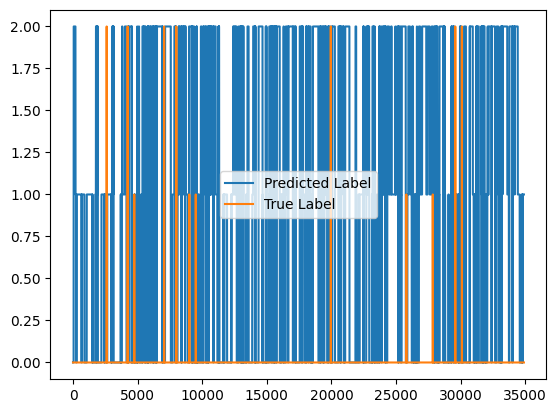

In [86]:

plt.plot(pred_label, label='Predicted Label')
plt.plot(true_label, label='True Label')
plt.legend()
plt.show()

In [87]:
(true_label == pred_label).sum() / len(true_label)

0.3535463533457515